In [1]:
from time import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from tqdm import tqdm_notebook
import torch.nn.functional as F
import torch.autograd as autograd
import pandas as pd
import gc
import scipy
import torch.nn.init as init
import seaborn as sns
import torch.distributions
from numpy.random import shuffle

from FrEIA.framework import InputNode, OutputNode, Node, ReversibleGraphNet
from FrEIA.modules import GLOWCouplingBlock, PermuteRandom
import FrEIA.framework as Ff
import FrEIA.modules as Fm
#import sys
#sys.path.append('/home/lenovo/Working/Notebook/Normal_mode_inversion/')

from tools import *

import importlib
import tools
importlib.reload(tools)
from tools import *

import validation_tools
importlib.reload(validation_tools)
from validation_tools import *

import Model_generator
importlib.reload(Model_generator)
from Model_generator import *

#import Nets
#from Nets import *
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from IPython.display import clear_output

In [9]:
obs_real = np.loadtxt("./data/new_obs_real.txt")
obs_std = np.loadtxt("./data/new_obs_err.txt")
obs_real = obs_real[:167]
obs_std = obs_std[:167]

obs_t_real = np.array([1.31929,1.43845,1.75019,1.92525,2.10340,
                       3.09907,3.25352,
                      2.29528,2.48487,2.75300,2.91257,3.83052,4.01381,
                      4.19269,4.36875,
                      3.20008,3.60368,5.05139,4.77537])*1000.
obs_t_std = np.array([0.17e-3, 0.08e-3,0.13e-3,0.12e-3,0.06e-3,
                     0.10e-3,0.06e-3,
                    0.22e-3,0.15e-3,0.33e-3,0.08e-3,0.21e-3,0.24e-3,0.22e-3,
                     0.53e-3,
                     1.73e-3,0.24e-3,0.23e-3,1.86e-3])*1000.
obs_real = np.concatenate([obs_real,obs_t_real])
obs_std = np.concatenate([obs_std,obs_t_std])

obs_min = np.loadtxt('./data/new_obs_min_0.txt')
obs_inter = np.loadtxt('./data/new_obs_inter_0.txt')

var_np = obs_std/obs_inter*2.
var_np = var_np[:INPUT_SIZE]

In [10]:
#load file
filename = './net/Forward_net.pth'
Forward_net = Flow(INPUT_SIZE).cuda()
state = torch.load(filename)
Forward_net.load_state_dict(state)
Forward_net.eval();

In [92]:
obs_fix1 = np.loadtxt('obs_val.txt')
obs_fix2 = np.loadtxt('./data/obs_fix2')
obs_fix3 = np.loadtxt('./data/obs_fix3')
obs_fix4 = np.loadtxt('./data/obs_fix4')
obs_fix5 = np.loadtxt('./data/obs_fix5')

In [12]:
err_dist = torch.distributions.MultivariateNormal(torch.zeros(INPUT_SIZE,dtype=torch.float32),
                                                                    torch.diag(torch.from_numpy(np.power(var_np,2))).
                                                                    type(torch.float32))
obs_tensor = torch.randn(BATCH_SIZE,INPUT_SIZE,device=device,dtype=torch.float32)
obs_tensor[:] = torch.tensor(obs_fix1[0],dtype=torch.float32)
obs_sample = obs_tensor + err_dist.sample((BATCH_SIZE,)).to('cuda')
ert_sample = Forward_net(obs_sample.to(device),rev=True,jac=False)[0].detach().cpu()

In [13]:
model_fix = torch.tensor(np.loadtxt('model_val.txt'),dtype=torch.float32)
obs_fix = torch.tensor(np.loadtxt('obs_val.txt'),dtype=torch.float32)
obs_sample = torch.tensor(np.loadtxt('obs_sample.txt'),dtype=torch.float32)
ert_sample = torch.tensor(np.loadtxt('ert_sample.txt'),dtype=torch.float32)

In [14]:
#load file
filename = './net/Inverse_flow0_val_1.pth'
Inverse_flow_old1 = Flow_cond(OUTPUT_SIZE,INPUT_SIZE).cuda()
state = torch.load(filename)
Inverse_flow_old1.load_state_dict(state)
Inverse_flow_old1.eval();

In [15]:
#load file
filename = './net/Inverse_flow0_val_2.pth'
Inverse_flow_old2 = Flow_cond(OUTPUT_SIZE,INPUT_SIZE).cuda()
state = torch.load(filename)
Inverse_flow_old2.load_state_dict(state)
Inverse_flow_old2.eval();

In [16]:
#load file
filename = './net/Inverse_flow0_val_3.pth'
Inverse_flow_old3 = Flow_cond(OUTPUT_SIZE,INPUT_SIZE).cuda()
state = torch.load(filename)
Inverse_flow_old3.load_state_dict(state)
Inverse_flow_old3.eval();

In [17]:
#load file
filename = './net/Inverse_flow0_val_4.pth'
Inverse_flow_old4 = Flow_cond(OUTPUT_SIZE,INPUT_SIZE).cuda()
state = torch.load(filename)
Inverse_flow_old4.load_state_dict(state)
Inverse_flow_old4.eval();

In [18]:
#load file
filename = './net/Inverse_flow1_1_val.pth'
Inverse_flow1 = Flow_cond(OUTPUT_SIZE,INPUT_SIZE).cuda()
state = torch.load(filename)
Inverse_flow1.load_state_dict(state)
Inverse_flow1.eval();

In [19]:
#load file
filename = './net/Obs_normal_2_val.pth'
Obs_Normal_Flow_s2 = Flow(INPUT_SIZE).cuda()
state = torch.load(filename)
Obs_Normal_Flow_s2.load_state_dict(state)
Obs_Normal_Flow_s2.eval();

In [20]:
#load file
filename = './net/Mod_normal_2_val.pth'
Mod_Normal_Flow_s2 = Flow(OUTPUT_SIZE).cuda()
state = torch.load(filename)
Mod_Normal_Flow_s2.load_state_dict(state)
Mod_Normal_Flow_s2.eval();

In [21]:
#load file
filename = './net/Inverse_flow_s2_val.pth'
Inverse_flow_s2 = Flow_cond(OUTPUT_SIZE,INPUT_SIZE).cuda()
state = torch.load(filename)
Inverse_flow_s2.load_state_dict(state)
Inverse_flow_s2.eval();

In [22]:
#load file
filename = './net/Obs_normal_3_val.pth'
Obs_Normal_Flow_s3 = Flow(INPUT_SIZE).cuda()
state = torch.load(filename)
Obs_Normal_Flow_s3.load_state_dict(state)
Obs_Normal_Flow_s3.eval();

In [23]:
#load file
filename = './net/Mod_normal_3_val.pth'
Mod_Normal_Flow_s3 = Flow(INPUT_SIZE).cuda()
state = torch.load(filename)
Mod_Normal_Flow_s3.load_state_dict(state)
Mod_Normal_Flow_s3.eval();

In [24]:
#load file
filename = './net/Inverse_flow_s3_val.pth'
Inverse_flow_s3 = Flow_cond(OUTPUT_SIZE,INPUT_SIZE).cuda()
state = torch.load(filename)
Inverse_flow_s3.load_state_dict(state)
Inverse_flow_s3.eval();

In [25]:
#load file
filename = './net/Obs_normal_4_val.pth'
Obs_Normal_Flow_s4 = Flow(INPUT_SIZE).cuda()
state = torch.load(filename)
Obs_Normal_Flow_s4.load_state_dict(state)
Obs_Normal_Flow_s4.eval();

In [26]:
#load file
filename = './net/Mod_normal_4_val.pth'
Mod_Normal_Flow_s4 = Flow(INPUT_SIZE).cuda()
state = torch.load(filename)
Mod_Normal_Flow_s4.load_state_dict(state)
Mod_Normal_Flow_s4.eval();

In [28]:
#load file
filename = './net/Inverse_flow_s4_val.pth'
Inverse_flow_s4 = Flow_cond(OUTPUT_SIZE,INPUT_SIZE).cuda()
state = torch.load(filename)
Inverse_flow_s4.load_state_dict(state)
Inverse_flow_s4.eval();

In [93]:
#load file
filename = './net/Obs_normal_5_val.pth'
Obs_Normal_Flow_s5 = Flow(INPUT_SIZE).cuda()
state = torch.load(filename)
Obs_Normal_Flow_s5.load_state_dict(state)
Obs_Normal_Flow_s5.eval();

In [94]:
#load file
filename = './net/Mod_normal_5_val.pth'
Mod_Normal_Flow_s5 = Flow(INPUT_SIZE).cuda()
state = torch.load(filename)
Mod_Normal_Flow_s5.load_state_dict(state)
Mod_Normal_Flow_s5.eval();

In [95]:
#load file
filename = './net/Inverse_flow_s5_val.pth'
Inverse_flow_s5 = Flow_cond(OUTPUT_SIZE,INPUT_SIZE).cuda()
state = torch.load(filename)
Inverse_flow_s5.load_state_dict(state)
Inverse_flow_s5.eval();

In [32]:
ert_sample.shape

torch.Size([256, 152])

In [97]:
BATCH_SIZE = 256
ert_fake = np.zeros((2,6,BATCH_SIZE,INPUT_SIZE))
obs_tensor = torch.randn(BATCH_SIZE,INPUT_SIZE,device=device,dtype=torch.float32)

ert_fake[1,5]=ert_sample.detach().cpu().numpy()
ert_fake[0,5]=ert_sample.detach().cpu().numpy()

rand_ert = torch.randn(BATCH_SIZE,OUTPUT_SIZE,device=device)

obs_tensor[:] = torch.tensor(obs_fix1[0],dtype=torch.float32)
ert_fake[0,0] = Inverse_flow_old1(rand_ert,obs_tensor,rev=True,jac=False)[0].detach().cpu().numpy() 
ert_fake[0,1] = Inverse_flow_old2(rand_ert,obs_tensor,rev=True,jac=False)[0].detach().cpu().numpy() 
ert_fake[0,2] = Inverse_flow_old3(rand_ert,obs_tensor,rev=True,jac=False)[0].detach().cpu().numpy() 
ert_fake[0,3] = Inverse_flow_old4(rand_ert,obs_tensor,rev=True,jac=False)[0].detach().cpu().numpy() 
ert_fake[0,4] = Inverse_flow_old4(rand_ert,obs_tensor,rev=True,jac=False)[0].detach().cpu().numpy()

ert_fake[1,0] = Inverse_flow1(rand_ert,obs_tensor,rev=True,jac=False)[0].detach().cpu().numpy()

obs_tensor[:] = torch.tensor(obs_fix2[0],dtype=torch.float32)
obs_code = Obs_Normal_Flow_s2(obs_tensor)[0].detach()
ert_fake_code = Inverse_flow_s2(rand_ert,obs_code,rev=True,jac=False)[0].detach()
ert_fake[1,1] = Mod_Normal_Flow_s2(ert_fake_code,rev=True,jac=False)[0].detach().cpu().numpy()

obs_tensor[:] = torch.tensor(obs_fix3[0],dtype=torch.float32)
obs_code = Obs_Normal_Flow_s3(obs_tensor)[0].detach()
ert_fake_code = Inverse_flow_s3(rand_ert,obs_code,rev=True,jac=False)[0].detach()
ert_fake[1,2] = Mod_Normal_Flow_s3(ert_fake_code,rev=True,jac=False)[0].detach().cpu().numpy()

obs_tensor[:] = torch.tensor(obs_fix4[0],dtype=torch.float32)
obs_code = Obs_Normal_Flow_s4(obs_tensor)[0].detach()
ert_fake_code = Inverse_flow_s4(rand_ert,obs_code,rev=True,jac=False)[0].detach()
ert_fake[1,3] = Mod_Normal_Flow_s4(ert_fake_code,rev=True,jac=False)[0].detach().cpu().numpy()

obs_tensor[:] = torch.tensor(obs_fix5[0],dtype=torch.float32)
obs_code = Obs_Normal_Flow_s5(obs_tensor)[0].detach()
ert_fake_code = Inverse_flow_s5(rand_ert,obs_code,rev=True,jac=False)[0].detach()
ert_fake[1,4] = Mod_Normal_Flow_s5(ert_fake_code,rev=True,jac=False)[0].detach().cpu().numpy()

In [34]:
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
g1 = (31/256,91/256,37/256)
g2 = (102/256,157/256,98/256)
g3 = (194/256,214/256,164/256)
g4 = (231/256,229/256,204/256)
cmap_colors=[g4,g3,g2,g1]
custom_cmap = LinearSegmentedColormap.from_list('CustomCmap', cmap_colors)

In [35]:
g1 = (31/256,91/256,37/256)
g2 = (102/256,157/256,98/256)
g3 = (194/256,214/256,164/256)
g4 = (231/256,229/256,204/256)

f1 = (231/256,229/256,204/256)
f2 = (194/256,214/256,164/256)
f3 = (156/256,193/256,132/256)
f4 = (102/256,157/256,98/256)
f5 = (60/256,124/256,61/256)
f6 = (31/256,91/256,37/256)
f7 = (30/256,61/256,20/256)
f8 = (25/256,40/256,19/256)

r1 = (238/256,190/256,4/256)
r2 = (233/256,160/256,14/256)
r3 = (217/256,112/256,14/256)
r4 = (189/256,49/256,6/256)

r1 = (91/256,31/256,37/256)
r2 = (157/256,102/256,98/256)
r3 = (214/256,194/256,164/256)
r4 = (229/256,231/256,204/256)

b1 = (27/256,22/256,91/256)
b2 = (98/256,110/256,157/256)
b3 = (164/256,194/256,214/256)
b4 = (201/256,234/256,229/256)


g = [g4,g3,g2,g1]
r = [r4,r3,r2,r1]
b = [b4,b3,b2,b1]
#cmap_colors=[f1,f2,f3,f4,f5,f6,f7,f8]
#cmap_colors=[f8,f7,f6,f5,f4,f3,f2,f1]
custom_cmap_b = LinearSegmentedColormap.from_list('CustomCmap', b)
custom_cmap_r = LinearSegmentedColormap.from_list('CustomCmap', r)
custom_cmap_g = LinearSegmentedColormap.from_list('CustomCmap', g)

/home/benjamin/anaconda3/envs/pt_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/benjamin/anaconda3/envs/pt_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/benjamin/anaconda3/envs/pt_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/benjamin/anaconda3/envs/pt_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

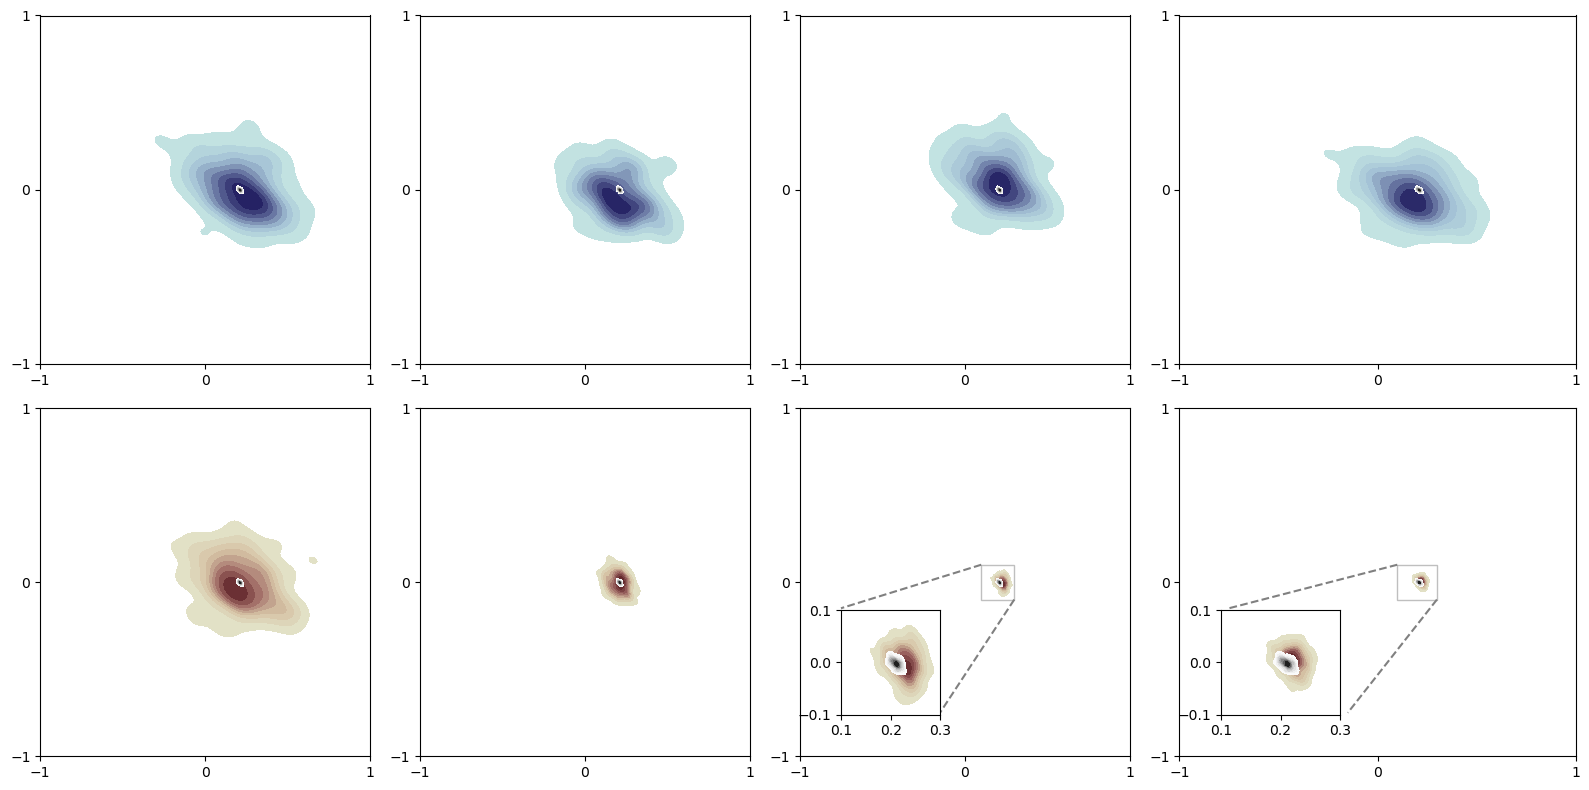

In [106]:
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

N1 = model_pair['Lm1_den']
N2 = model_pair['Lm1_vpv']

norm = Normalize(vmin=0, vmax=1)

fig,ax = plt.subplots(2,4,figsize=(16,8), gridspec_kw={'width_ratios': [1, 1, 1, 1.2]})

text = ['10k epoches','20k epoches','30k epoches','40k epoches','Real Poterior PDF']
for i in range(2):
    for j in range(4):
        if i == 0:
            cmap = custom_cmap_b
            kde_plot = sns.kdeplot(x=ert_fake[i,j,:,N1],y=ert_fake[i,j,:,N2],common_norm=False,fill=True,cmap=cmap,ax=ax[i,j],cbar=j==4,
                                  cbar_kws={'ticks':[],'norm': norm})
        if i == 1:
            cmap = custom_cmap_r
            kde_plot = sns.kdeplot(x=ert_fake[i,j,:,N1],y=ert_fake[i,j,:,N2], common_norm=False,fill=True,cmap=cmap,ax=ax[i,j],cbar=j==4,
                                cbar_kws={'ticks':[],'norm': norm})
        kde_plot = sns.kdeplot(x=ert_fake[i,5,:,N1],y=ert_fake[i,5,:,N2], common_norm=False,fill=True,cmap='Greys',ax=ax[i,j])
        if i == 0 and j == 0:
            cbar_mappable = kde_plot.get_children()[0]
        ax[i,j].set_xticks([-1,0,1])
        ax[i,j].set_yticks([-1,0,1])
        ax[i,j].set_xlim([-1,1])
        ax[i,j].set_ylim([-1,1]) 


axins = inset_axes(ax[1, 2], width="30%", height="30%", loc='lower left', borderpad=3)
sns.kdeplot(x=ert_fake[1, 2, :, N1], y=ert_fake[1, 2, :, N2], common_norm=False, fill=True, cmap=cmap, ax=axins)
sns.kdeplot(x=ert_fake[1, 5, :, N1], y=ert_fake[i, 5, :, N2], common_norm=False,fill=True,  cmap='Greys',ax=axins)


x1, x2, y1, y2 = 0.1, 0.3, -0.1, 0.1
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticks([x1, (x1+x2)/2, x2])
axins.set_yticks([y1, (y1+y2)/2, y2])


ax[1, 2].indicate_inset_zoom(axins)


ax[1, 2].plot([x1, -0.75], [y2,-0.15], linestyle='--', color='grey')
ax[1, 2].plot([x2, -0.15], [y1,-0.75], linestyle='--', color='grey')


axins = inset_axes(ax[1, 3], width="30%", height="30%", loc='lower left', borderpad=3)
sns.kdeplot(x=ert_fake[1, 3, :, N1], y=ert_fake[1, 3, :, N2], common_norm=False, fill=True, cmap=cmap, ax=axins)
sns.kdeplot(x=ert_fake[1, 5, :, N1], y=ert_fake[i, 5, :, N2], common_norm=False,fill=True,  cmap='Greys',ax=axins)


x1, x2, y1, y2 = 0.1, 0.3, -0.1, 0.1
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticks([x1, (x1+x2)/2, x2])
axins.set_yticks([y1, (y1+y2)/2, y2])


ax[1, 3].indicate_inset_zoom(axins)


ax[1, 3].plot([x1, -0.75], [y2,-0.15], linestyle='--', color='grey')
ax[1, 3].plot([x2, -0.15], [y1,-0.75], linestyle='--', color='grey')


#cbar = plt.colorbar(ax[0,3].collections[0],ticks=[0,0.3,0.6])
#cbar.set_ticklabels(['0','3','6'])
plt.tight_layout()
plt.savefig('validation_Lm.png',dpi=300)

In [102]:
ce1 = np.loadtxt('./data/cross_entorpy1.txt')
ce2 = np.loadtxt('./data/cross_entorpy2.txt')
cross_entorpy1_1 = np.loadtxt('./data/cross_entorpy1_1.txt')
cross_entorpy2_1 = np.loadtxt('./data/cross_entorpy2_1.txt')
cross_entorpy1_2 = np.loadtxt('./data/cross_entorpy1_2.txt')
cross_entorpy2_2 = np.loadtxt('./data/cross_entorpy2_2.txt')
cross_entorpy1_3 = np.loadtxt('./data/cross_entorpy1_3.txt')
cross_entorpy2_3 = np.loadtxt('./data/cross_entorpy2_3.txt')
cross_entorpy1_4 = np.loadtxt('./data/cross_entorpy1_4.txt')
cross_entorpy2_4 = np.loadtxt('./data/cross_entorpy2_4.txt')
cross_entorpy1_5 = np.loadtxt('./data/cross_entorpy1_5.txt')
cross_entorpy2_5 = np.loadtxt('./data/cross_entorpy2_5.txt')

In [107]:
c=np.concatenate([cross_entorpy2_1,cross_entorpy1_2+cross_entorpy2_2,cross_entorpy1_3[:100]+cross_entorpy2_3[:100],cross_entorpy1_4[:100]+cross_entorpy2_4[:100]],axis=0)

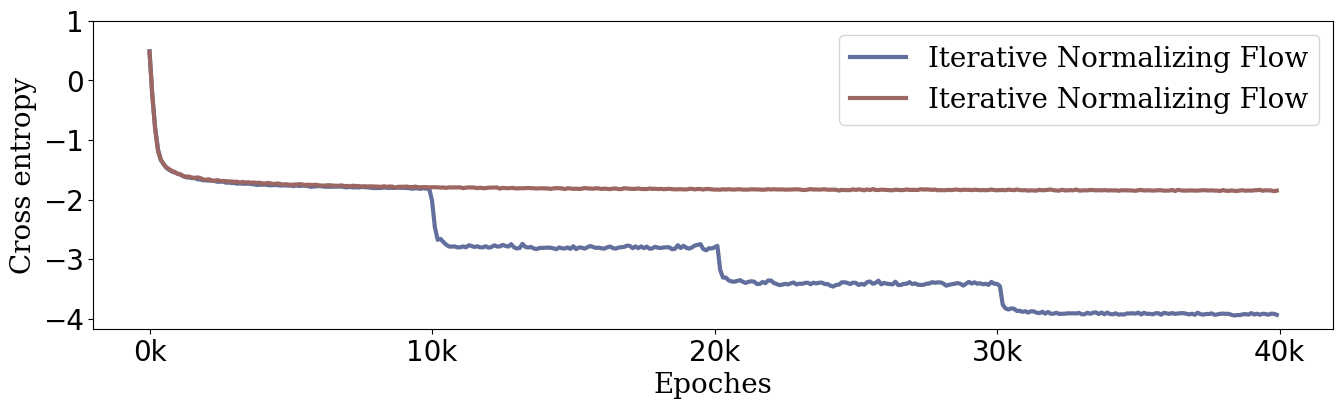

In [151]:
fig = plt.figure(figsize=(16,4))
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        }
font2 = {'family': 'serif',
        'weight': 'normal',
        'size': 20,
        }
N = 400
x = np.arange(0,40,0.1)
plt.plot(x,c[:N],lw=3.,label='Iterative Normalizing Flow',c=b2)
plt.plot(x,ce2[:N],lw=3.,label='Iterative Normalizing Flow',c=r2)
# 获取当前的Axes对象
ax = plt.gca()

# 设置 x 轴刻度的字体属性
ax.tick_params(axis='x', which='both',
 labelsize=20, color=font['color'], labelcolor=font['color'])
ax.tick_params(axis='y', which='both', labelsize=20, color=font['color'], labelcolor=font['color'])


# 设置 x 轴刻度值
xticks_values = [0, 10, 20, 30, 40]
ax.set_xticks(xticks_values)
ax.set_yticks([-4,-3,-2,-1,0,1])
xticks_labels = [f"{val}k" for val in xticks_values]
plt.xticks(xticks_values, labels=xticks_labels)
plt.xlabel('Epoches',fontdict=font)
plt.ylabel('Cross entropy',fontdict=font)
plt.legend(prop=font2)
plt.savefig('KL.png',dpi=300)

In [155]:
c[-1]

-3.9089924097061157

In [66]:
x.shape, c.shape

((400,), (401,))

In [119]:
ert_val = torch.tensor(ert_fake[1,4],dtype=torch.float32,device=device)
obs_val = Forward_net(ert_val)[0].detach().cpu().numpy()
diff1 = (obs_val-obs_fix.detach().cpu().numpy()[0])*obs_inter[:INPUT_SIZE]

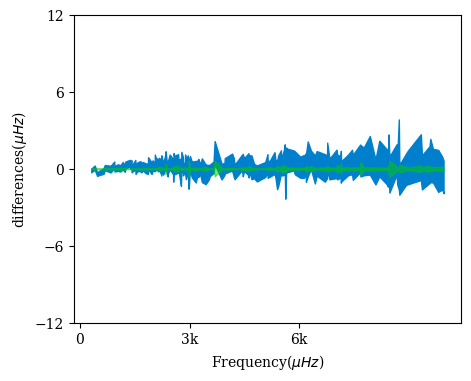

In [120]:
#plt.style.use('_mpl-gallery')
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 10,
        }

x = obs_real[:INPUT_SIZE]
y1 = diff1.std(axis=0)
y2 = diff1.mean(axis=0)
sort_index = np.argsort(x)
x_sorted = x[sort_index]
y1_sorted1 = y1[sort_index]
y2_sorted1 = y2[sort_index]
obs_std_sorted = obs_std[sort_index]

#fig,ax = plt.subplots(figsize=(3.5,2.5))
fig,ax = plt.subplots(figsize=(5.0,4.0))
ax.fill_between(x_sorted/1000,y2_sorted1+y1_sorted1,y2_sorted1-y1_sorted1,color=(.0,.5,.8))
ax.fill_between(x_sorted/1000,obs_std_sorted,-obs_std_sorted,color=(.0,0.8,0.0),alpha=0.5)
ax.grid(False)
ax.set_ylabel('differences($\mu Hz$)',fontdict=font)
ax.set_xlabel('Frequency($\mu Hz$)',fontdict=font)
ax.set_xticks([0,3,6])
ax.set_xticklabels(['0','3k','6k'])
ax.set_yticks([-12,-6,0,6,12])

for label in ax.get_xticklabels()+ax.get_yticklabels():
    label.set_fontname('serif')
fig.savefig('validation_std_diff.png',dpi=300)

In [125]:
ert_val = torch.tensor(ert_fake[0,2],dtype=torch.float32,device=device)
obs_val = Forward_net(ert_val)[0].detach().cpu().numpy()
diff = (obs_val-obs_fix.detach().cpu().numpy()[0])*obs_inter[:INPUT_SIZE]

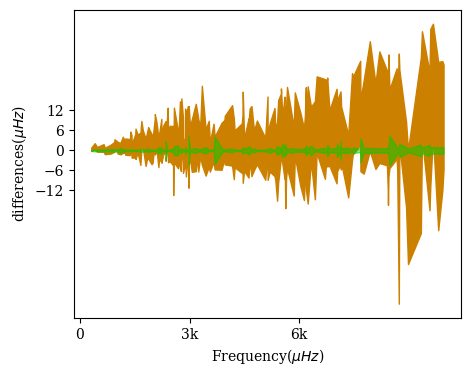

In [153]:
#plt.style.use('_mpl-gallery')
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 10,
        }

x = obs_real[:INPUT_SIZE]
y1 = diff.std(axis=0)
y2 = diff.mean(axis=0)
sort_index = np.argsort(x)
x_sorted = x[sort_index]
y1_sorted = y1[sort_index]
y2_sorted = y2[sort_index]
obs_std_sorted = obs_std[sort_index]

#fig,ax = plt.subplots(figsize=(3.5,2.5))
fig,ax = plt.subplots(figsize=(5.0,4.0))
ax.fill_between(x_sorted/1000,y2_sorted+y1_sorted,y2_sorted-y1_sorted,color=(.8,.5,0.0))
ax.fill_between(x_sorted/1000,obs_std_sorted*7.,-obs_std_sorted*7.,color=(.0,0.8,0.0),alpha=0.5)
ax.grid(False)
ax.set_ylabel('differences($\mu Hz$)',fontdict=font)
ax.set_xlabel('Frequency($\mu Hz$)',fontdict=font)
ax.set_xticks([0,3,6])
ax.set_xticklabels(['0','3k','6k'])
ax.set_yticks([-12,-6,0,6,12])

for label in ax.get_xticklabels()+ax.get_yticklabels():
    label.set_fontname('serif')
fig.savefig('validation_std_diff2.png',dpi=300)

In [124]:
ymin2.shape

(64,)

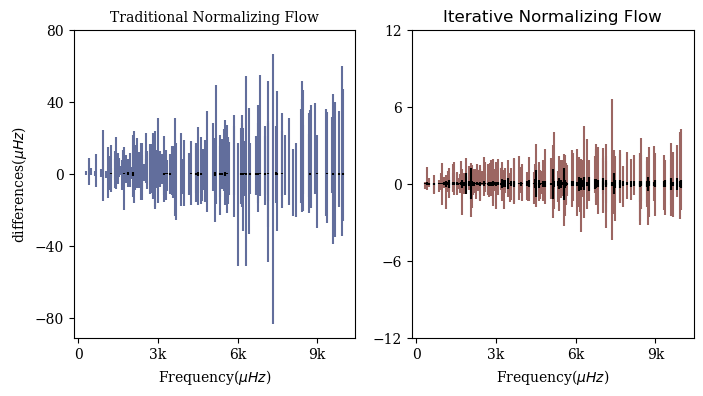

In [154]:
fig,(ax2,ax1) = plt.subplots(1,2,figsize=(8.0,4.0))

ymax = 2.*obs_std_sorted
ymin = -2.*obs_std_sorted

ymax1 = y2_sorted1+2.*y1_sorted1
ymin1 = y2_sorted1-2.*y1_sorted1

ymax2 = y2_sorted+2.*y1_sorted
ymin2 = y2_sorted-2.*y1_sorted

ax1.vlines(x,ymax1,ymin1,color=r2)
ax1.vlines(x,ymax,ymin,color='k')


ax1.set_xlabel('Frequency($\mu Hz$)',fontdict=font)
ax1.set_xticks([0,3000,6000,9000])
ax1.set_xticklabels(['0','3k','6k','9k'])
ax1.set_yticks([-12,-6,0,6,12])
ax1.set_title('Iterative Normalizing Flow')

for label in ax1.get_xticklabels()+ax1.get_yticklabels():
    label.set_fontname('serif')


ax2.vlines(x,ymax2,ymin2,color=b2)
ax2.vlines(x,ymax,ymin,color='k')

ax2.set_ylabel('differences($\mu Hz$)',fontdict=font)
ax2.set_xlabel('Frequency($\mu Hz$)',fontdict=font)
ax2.set_xticks([0,3000,6000,9000])
ax2.set_xticklabels(['0','3k','6k','9k'])
ax2.set_yticks([-80,-40,0,40,80])
ax2.set_title('Traditional Normalizing Flow',fontdict=font)

for label in ax2.get_xticklabels()+ax2.get_yticklabels():
    label.set_fontname('serif')

fig.savefig('validation_std_diff.png',dpi=300)

In [161]:
((y1_sorted1/ymax)<10).sum()/ymax.shape

array([0.86842105])

In [163]:
(y1_sorted1/ymax).argmax()

40

In [165]:
ymax[40]

0.02

In [166]:
INPUT_SIZE

152